In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import xgboost

In [4]:
plt.style.use('ggplot')

#### Data

In [5]:
data_folder = "../data"

In [6]:
df_item_categories = pd.read_csv(os.path.join(data_folder, "item_categories.csv"))
df_items = pd.read_csv(os.path.join(data_folder, "items.csv"))
df_shops = pd.read_csv(os.path.join(data_folder, "shops.csv"))
df_sales_train = pd.read_csv(os.path.join(data_folder, "sales_train_v2.csv")) 
df_test = pd.read_csv(os.path.join(data_folder, "test.csv"))

In [7]:
df_sales_train["date"] = pd.to_datetime(df_sales_train.date, format="%d.%m.%Y")
df_sales_train["year"] = df_sales_train.date.dt.year
df_sales_train["month"] = df_sales_train.date.dt.month
df_sales_train["day"] = df_sales_train.date.dt.day

#### Adding features

In [8]:
df_sales_train = df_sales_train.merge(df_items[["item_id", "item_category_id"]], on="item_id", how="left")

In [9]:
df_test = df_test.merge(df_items[["item_id", "item_category_id"]], on="item_id", how="left")

In [10]:
import calendar
def get_weekend(month, year):
    days = [calendar.SATURDAY, calendar.SUNDAY]
    matrix = calendar.monthcalendar(year, month)
    num_days = sum(sum(bool(x[day]) for day in days) for x in matrix)
    return num_days

In [11]:
from itertools import product
years = [2013, 2014, 2015]
months = range(1, 13)
years, months = list(zip(*product(years, months)))
num_weekends = [get_weekend(month, year) for month, year in zip(months, years)] 
df_num_weekends = pd.DataFrame({"month": months, "year": years, "num_weekends": num_weekends})

In [12]:
df_sales_train = df_sales_train.merge(df_num_weekends, on=["month", "year"], how="left")

In [13]:
df_test["num_weekends"] = get_weekend(11, 2015)

In [14]:
df_conversion_rate = pd.read_csv("../data/conversion_rates.csv")

In [15]:
df_sales_train = df_sales_train.merge(df_conversion_rate, on=["month", 'year'], how="left")

In [16]:
df_test["rate"] =  df_conversion_rate.iloc[34].rate

In [17]:
occurance_shop_item = (pd.concat((df_sales_train[["shop_id", "item_id"]], df_test[["shop_id", "item_id"]]))
                       .groupby(["shop_id", "item_id"])
                       .size()
                       .apply(np.log1p)
                       .reset_index()
                       .rename(columns={0: "occurance"}))

In [18]:
df_sales_train = df_sales_train.merge(occurance_shop_item, on=["shop_id", "item_id"], how="left")

In [19]:
df_test = df_test.merge(occurance_shop_item, on=["shop_id", "item_id"], how="left")

In [20]:
df_category_size = (df_items
                    .groupby("item_category_id")
                    .size()
                    .apply(np.log1p)
                    .rename("category_size")
                    .reset_index())

In [21]:
df_sales_train = df_sales_train.merge(df_category_size, on="item_category_id", how="left")

In [22]:
df_test = df_test.merge(df_category_size, on="item_category_id", how="left")

In [23]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,item_category_id,num_weekends,rate,occurance,category_size
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,37,8,30.2716,1.098612,7.484930
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,58,8,30.2716,1.098612,6.673298
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,58,8,30.2716,1.098612,6.673298
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,58,8,30.2716,0.693147,6.673298
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,56,8,30.2716,2.397895,5.986452


**Lets not use `item price` for the first model**

In [24]:
df_sales_train = df_sales_train.drop(["date", "day", "item_price"], axis=1)

In [25]:
df_sales_train = (df_sales_train
                  .groupby(["date_block_num", "shop_id", "item_id"])
                  .aggregate({"item_cnt_day": "sum",
                              "year": "first",
                              "month": "first",
                              "item_category_id": "first",
                              "num_weekends": "first",
                              "rate": "first",
                              "occurance": "first",
                              "category_size": "first"})
                  .reset_index())

In [26]:
df_sales_train = df_sales_train.rename(columns={"item_cnt_day": "item_cnt_month"})

In [27]:
df_sales_train["item_cnt_month"] = df_sales_train.item_cnt_month.clip(0, 20)

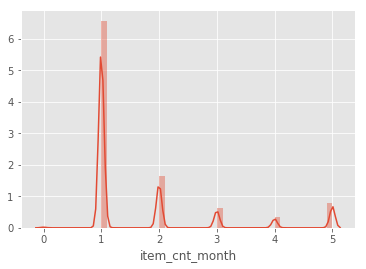

In [28]:
sns.distplot(df_sales_train.item_cnt_month.clip(0, 5))

In [29]:
df_sales_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'num_weekends', 'occurance',
       'month', 'rate', 'category_size', 'year', 'item_cnt_month',
       'item_category_id'],
      dtype='object')

In [30]:
df_sales_train["shop_id"] = df_sales_train["shop_id"].astype(str)
df_sales_train["item_id"] = df_sales_train["item_id"].astype(str)

In [31]:
X = df_sales_train.drop("item_cnt_month", axis=1)

In [32]:
y = df_sales_train.item_cnt_month

### XGBoost model

In [33]:
from xgboost import XGBRegressor, plot_importance

In [37]:
import xgboost as xgb

In [34]:
X_train = X[df_sales_train.date_block_num != 33]
y_train = y[df_sales_train.date_block_num != 33]

X_test = X[df_sales_train.date_block_num == 33]
y_test = y[df_sales_train.date_block_num == 33]

In [38]:
train = xgb.DMatrix(X_train.values, y_train.values)

In [43]:
test = xgb.DMatrix(X_test.values, y_test.values)

In [46]:
params = dict(max_depth=8,
              num_boost_round=100,
              min_child_weight=300,
              colsample_bytree=0.9,
              subsample=0.9,
              eta=0.15,
              seed=42,
              evals=[(train, "train"), (test, "eval")],
              eval_metric="rmse",
              verbose=True)

In [48]:
bst = xgb.train(params, train)

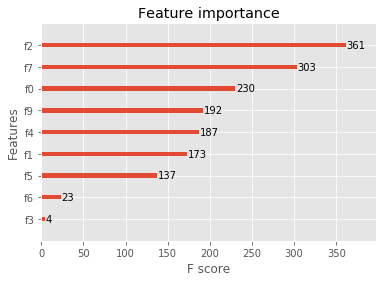

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f2badb72ba8>>
Traceback (most recent call last):
  File "/home/abhishek/anaconda3/envs/deep_learning/lib/python3.5/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [55]:
plot_importance(bst)

In [35]:
model = XGBRegressor(max_depth=8,
                     n_estimators=1000,
                     min_child_weight=300,
                     colsample_bytree=0.9,
                     subsample=0.9,
                     eta=0.15,
                     seed=42)

In [36]:
model.fit(X_train,
          y_train,
          eval_metric="rmse",
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True,
          early_stopping_rounds=10)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields shop_id, item_id

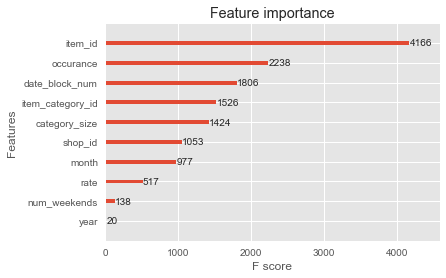

In [43]:
plot_importance(model)

In [44]:
df_test["date_block_num"] = 34
df_test["year"] = 2015
df_test["month"] = 11

In [32]:
df_sales_train.date_block_num.max()

33

In [54]:
train_shops_items = df_sales_train.groupby(["shop_id", "item_id"]).indices.keys()

In [55]:
df_test["present_in_train"] = df_test.apply(lambda x: (x.shop_id, x.item_id) in train_shops_items, axis=1)

In [56]:
y_pred = model.predict(df_test[X_train.columns])

**conservative approach** If a item-shop pair not present in the train data, then predict $0$ for it.

In [59]:
y_pred[~df_test.present_in_train] = 0

In [60]:
y_oct_pred = pd.read_csv("../data/october_pred.csv")

In [61]:
y_gdb_pred = y_oct_pred[:]

In [67]:
y_gdb_pred["item_cnt_month"] = ((y_gdb_pred.item_cnt_month + y_pred) / 2).clip_upper(20)

In [68]:
y_gdb_pred.to_csv("../data/gdb_plus_prev_month_pred_avg.csv", index=False)

**This method gives RMSE score 1.2737 which is worse than the previous month baseline**.

In the train data, I am giving $0$ sales predictions for all the items that are not present in the test data based on the observations that the test data is uniformally sampled from all items. May be origanizer have delibrately removed some data and want us to predict the sales for that data.